# PANDA HANDLER

In [35]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as dates
import mpl_finance as candle
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DayLocator, MONDAY
from pylab import rcParams


%matplotlib inline

In [94]:
df = pd.read_excel('BMF2018.xlsx')

# 1.1 - PEGANDO BLUE CHIPS

In [95]:
bmf2018 = df
bmf2018.tail()

,TIPO DE REGISTRO,DATA DO PREGAO,CODIGO BDI,CODIGO DE NEGOCIACAO DO PAPEL,TIPO DE MERCADO,NOME RESUMIDO DA EMPRESA EMISSORA,ESPECIFICACAO DO PAPEL,MOEDA DE REFERENCIA,PRECO DE ABERTURA,PRECO MAXIMO,...,PRECO MELHOR OFERTA COMPRA,PRECO MELHOR OFERTA DE VENDA,NUMERO DE NEGOCIOS EFETUADOS COM O PAPEL,QUANTIDADE TOTAL DE TITULOS NEGOCIADOS,VOLUME TOTAL DE TITULOS NEGOCIADOS NESTE PAPEL,PRECO DE EXERCICIO OPCAO,Unnamed: 19,Unnamed: 20,CODIGO DO PAPEL NO SISTEMA,NUMERO DE DISTRIBUICAO DO PAPEL
580151,1,20181228,12.0,XPLG11,10,FII XP LOG,CI,R$,10000.0,10030.0,...,10000.0,10030.0,804.0,17310.0,172940811.0,0.0,9.999123e+14,0.0,BRXPLGCTF002,106.0
580152,1,20181228,12.0,XPML11,10,FII XP MALLS,CI ER,R$,10790.0,10800.0,...,10750.0,10780.0,1321.0,20067.0,215038945.0,0.0,9.999123e+14,0.0,BRXPMLCTF000,113.0
580153,1,20181228,14.0,XPOM11,10,FIP XP OMEGA,CI,R$,10301.0,10301.0,...,10300.0,10599.0,5.0,494.0,5088600.0,0.0,9.999123e+14,0.0,BRXPOMCTF004,115.0
580154,1,20181228,12.0,XTED11,10,FII TRXE COR,CI,R$,1751.0,1790.0,...,1751.0,1790.0,23.0,222.0,390676.0,0.0,9.999123e+14,0.0,BRXTEDCTF006,143.0
580155,99,COTAHIST,0.2,018BOVESPA 2,18,122800000580,157,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# PRIMEITO AGRUPA DE ACORDO COM ATIVO
df_gb = bmf2018.groupby('CODIGO DE NEGOCIACAO DO PAPEL')

# DEPOIS SOMA O VOLUME E ORDENAR DECRESCENTE
bc = df_gb.sum()['VOLUME TOTAL DE TITULOS NEGOCIADOS NESTE PAPEL'].sort_values(ascending=False)

# CRIA INDICE PARA O NOME DO ATIVO DEIXAR DE SER O INDICE
blue_chips = bc.reset_index()['CODIGO DE NEGOCIACAO DO PAPEL']

# SELECIONA SOMENTE OS 100 ATIVOS QUE TEM NOME PADRAO (EXCLUI MERCADO A TERMO, FIIs, ETC)  
blue_chips = blue_chips[blue_chips.apply(lambda name: len(name) <= 5)].iloc[:104]

# SALVA NUM CSV
blue_chips = blue_chips.to_frame()
blue_chips.to_csv('BLUECHIPS',index=False)

In [99]:
blue_chips.nunique()

CODIGO DE NEGOCIACAO DO PAPEL    104
dtype: int64

# 1.2 - GERANDO TABELA DE CADA BLUE CHIP

In [100]:
i = 0
notblue = []
for bc_code in blue_chips['CODIGO DE NEGOCIACAO DO PAPEL']:
    # PEGA SOMENTE OS QUE TEM O CODIGO QUE EU QUERO (PARA CADA 'BC_CODE' - BLUE CHIP)
    stock = bmf2018[bmf2018['CODIGO DE NEGOCIACAO DO PAPEL'] == bc_code].reset_index()
    # SELECIONA AS COLUNAS IMPORTANTES
    colunas_importantes = ['DATA DO PREGAO', 'CODIGO DE NEGOCIACAO DO PAPEL', 'NOME RESUMIDO DA EMPRESA EMISSORA', 'PRECO DE ABERTURA', 'PRECO MAXIMO', 'PRECO MINIMO', 'PRECO FECHAMENTO', 'VOLUME TOTAL DE TITULOS NEGOCIADOS NESTE PAPEL']
    stock = stock[colunas_importantes]
    # AJUSTE DE VALOR
    stock['PRECO MAXIMO'] = stock['PRECO MAXIMO']/100
    stock['PRECO MINIMO'] = stock['PRECO MINIMO']/100
    stock['PRECO DE ABERTURA'] = stock['PRECO DE ABERTURA']/100
    stock['PRECO FECHAMENTO'] = stock['PRECO FECHAMENTO']/100
    stock['VOLUME TOTAL DE TITULOS NEGOCIADOS NESTE PAPEL'] = stock['VOLUME TOTAL DE TITULOS NEGOCIADOS NESTE PAPEL']/100
    # CRIA COLUNAS DE ESTATISTICA
    stock['MA_20'] = stock['PRECO FECHAMENTO'].rolling(window=20).mean()
    stock['MA_40'] = stock['PRECO FECHAMENTO'].rolling(window=40).mean()
    stock['STD_20'] = stock['PRECO FECHAMENTO'].rolling(window=20).std()
    stock['STD_40'] = stock['PRECO FECHAMENTO'].rolling(window=40).std()
    stock['BANDA_1_40 SUPERIOR'] = stock['MA_40'] + 2* stock['STD_40']
    stock['BANDA_1_40 INFERIOR'] = stock['MA_40'] - 2* stock['STD_40']
    stock['BANDA_2_40 SUPERIOR'] = stock['MA_40'] + 3* stock['STD_40']
    stock['BANDA_2_40 INFERIOR'] = stock['MA_40'] - 3* stock['STD_40']
    stock['BANDA_3_40 SUPERIOR'] = stock['MA_40'] + 4* stock['STD_40']
    stock['BANDA_3_40 INFERIOR'] = stock['MA_40'] - 4* stock['STD_40']
    stock = stock.fillna(value=0)
    # SALVA NA PASTA
    if len(stock) == 245: # QUANTIDADE DE DIAS DE MERCADO ABERTO 2018
        save_dir = 'HISTORICO_2018/' + stock['CODIGO DE NEGOCIACAO DO PAPEL'].iloc[0] + '_2018'
        stock.to_csv(save_dir,index=False)
    else:
        notblue.append(stock['CODIGO DE NEGOCIACAO DO PAPEL'].iloc[0])        

In [101]:
notblue

['B3SA3', 'BVMF3', 'HAPV3', 'GNDI3']

In [114]:
# Refaz blue_chips removendo ativos com tempo de vida conflitante
df = pd.read_csv('BLUECHIPS')
for remove_blue in notblue:
    df = df[df['CODIGO DE NEGOCIACAO DO PAPEL'] != remove_blue]
df.to_csv('BLUECHIPS',index=False)

# 1.3 - GERANDO GRÁFICO

In [2]:
stock = pd.read_csv('HISTORICO_2018/PETR4_2018', index_col = 'DATA DO PREGAO', parse_dates=True)
stock.head()

,CODIGO DE NEGOCIACAO DO PAPEL,NOME RESUMIDO DA EMPRESA EMISSORA,PRECO DE ABERTURA,PRECO MAXIMO,PRECO MINIMO,PRECO FECHAMENTO,VOLUME TOTAL DE TITULOS NEGOCIADOS NESTE PAPEL,MA_20,MA_40,STD_20,STD_40,BANDA_1_40 SUPERIOR,BANDA_1_40 INFERIOR,BANDA_2_40 SUPERIOR,BANDA_2_40 INFERIOR,BANDA_3_40 SUPERIOR,BANDA_3_40 INFERIOR
DATA DO PREGAO,,,,,,,,,,,,,,,,,
2018-01-02,PETR4,PETROBRAS,16.19,16.55,16.19,16.55,549628149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,PETR4,PETROBRAS,16.49,16.72,16.37,16.70,927610016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,PETR4,PETROBRAS,16.78,16.96,16.62,16.73,624099864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,PETR4,PETROBRAS,16.70,16.86,16.57,16.83,452007598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-08,PETR4,PETROBRAS,16.74,17.03,16.71,17.03,480575914.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


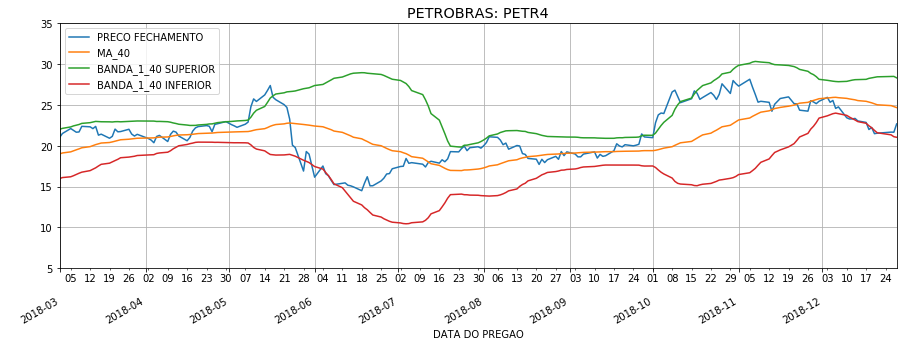

In [3]:
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

stock_plt = stock[['PRECO FECHAMENTO','MA_40','BANDA_1_40 SUPERIOR','BANDA_1_40 INFERIOR']].plot
title_stg = stock['NOME RESUMIDO DA EMPRESA EMISSORA'].iloc[0] + ": " + stock['CODIGO DE NEGOCIACAO DO PAPEL'].iloc[0]
stock_plt = stock_plt.line(title = title_stg)

stock_plt.set_ylim([5, 35])
stock_plt.set_xlim(['2018-03-01', '2018-12-28'])
stock_plt.grid()
stock_plt.xaxis.set_major_locator(dates.MonthLocator())
stock_plt.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y-%m'))
stock_plt.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=0))
stock_plt.xaxis.set_minor_formatter(dates.DateFormatter('%d'))



# 2.1 - CRIANDO TABELAS AUXILIARES DAS ESTRATEGIAS 
# (CREATE STRATEGIES)

In [136]:
blue_chips = pd.read_csv('BLUECHIPS')

df = pd.DataFrame()
df['CODIGO DE NEGOCIACAO DO PAPEL'] = blue_chips['CODIGO DE NEGOCIACAO DO PAPEL'].unique()
df['ESTADO'] = 'PROCURANDO ENTRADA'
df['AUX'] = 'EMPTY'


save_dir = 'STRATEGIES/BollingerBand'
df.to_csv(save_dir,index=False)


In [137]:
df = pd.read_csv('STRATEGIES/BollingerBand')
df.head()

,CODIGO DE NEGOCIACAO DO PAPEL,ESTADO,AUX
0,PETR4,PROCURANDO ENTRADA,EMPTY
1,VALE3,PROCURANDO ENTRADA,EMPTY
2,ITUB4,PROCURANDO ENTRADA,EMPTY
3,BBDC4,PROCURANDO ENTRADA,EMPTY
4,BBAS3,PROCURANDO ENTRADA,EMPTY


In [138]:
df = df.set_index('CODIGO DE NEGOCIACAO DO PAPEL')

df.loc['PETR4']['ESTADO']

'PROCURANDO ENTRADA'

# 2.2 - TABELAS DE BACK TEST 
# (CREATE BACK_TEST)

In [139]:
df = pd.DataFrame()
df['CODIGO DE NEGOCIACAO DO PAPEL'] = ['']
df['DATA DO PREGAO'] = ['']
df['PRECO'] = ['']
df['OPERACAO'] = ['']

save_dir = 'BACK_TEST/BollingerBand'
df.to_csv(save_dir,index=False)

In [140]:
df

,CODIGO DE NEGOCIACAO DO PAPEL,DATA DO PREGAO,PRECO,OPERACAO
0,,,,


# 3.1 - BENCHMARKING
# (READ BACK_TEST)

In [259]:
# RUN AFTER DF CREATED BY DOM !!!

In [88]:
df = pd.read_csv('BACK_TEST/BollingerBand')
df = df.dropna()
df['DATA DO PREGAO'] = df['DATA DO PREGAO'].apply(lambda name: int(name) )
save_dir = 'BACK_TEST/BollingerBand'
df.to_csv(save_dir,index=False)
df = pd.read_csv('BACK_TEST/BollingerBand', parse_dates=['DATA DO PREGAO'])
print(len(df))
df.head()

1203


,CODIGO DE NEGOCIACAO DO PAPEL,DATA DO PREGAO,PRECO,OPERACAO
0,ABEV3,2018-03-01,22.529268,SELL
1,GGBR4,2018-03-01,17.090248,SELL
2,MGLU3,2018-03-01,90.794397,SELL
3,GOAU4,2018-03-01,8.114165,SELL
4,UGPA3,2018-03-01,75.205725,BUY


# 3.2 - GERANDO GRAFICO COMPRA/VENDA

In [4]:
# PETR4
df = pd.read_csv('BACK_TEST/BollingerBand', parse_dates=['DATA DO PREGAO'])
df = df[df['CODIGO DE NEGOCIACAO DO PAPEL'] == 'PETR4'].reset_index()

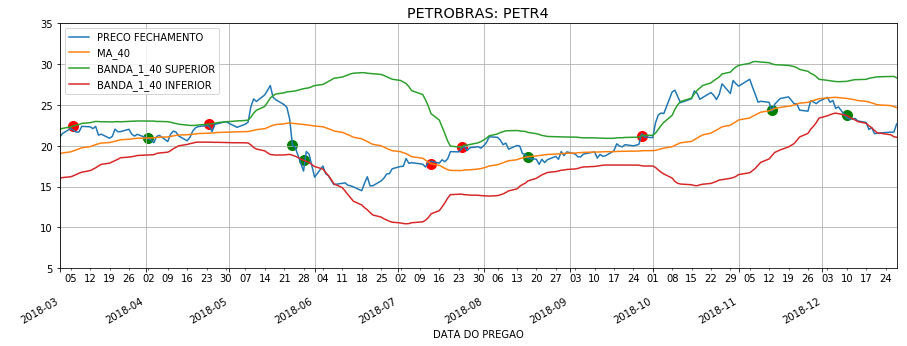

In [5]:
stock = pd.read_csv('HISTORICO_2018/PETR4_2018', index_col = 'DATA DO PREGAO', parse_dates=True)
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

stock_plt = stock[['PRECO FECHAMENTO','MA_40','BANDA_1_40 SUPERIOR','BANDA_1_40 INFERIOR']].plot
title_stg = stock['NOME RESUMIDO DA EMPRESA EMISSORA'].iloc[0] + ": " + stock['CODIGO DE NEGOCIACAO DO PAPEL'].iloc[0]
stock_plt = stock_plt.line(title = title_stg)

stock_plt.set_ylim([5, 35])
stock_plt.set_xlim(['2018-03-01', '2018-12-28'])

stock_plt.grid()
stock_plt.xaxis.set_major_locator(dates.MonthLocator())
stock_plt.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y-%m'))
stock_plt.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=0))
stock_plt.xaxis.set_minor_formatter(dates.DateFormatter('%d'))


for each_order in range(len(df)):
    if df['OPERACAO'].iloc[each_order] == 'SELL':
        cor = 'red'
    else:
        cor = 'green'
    stock_plt.scatter(df['DATA DO PREGAO'].iloc[each_order], df['PRECO'].iloc[each_order], s=100, c=cor)



Aparentemente teve gap do candle em 24 do 5, por isso demorou para fechar a primeira operação
https://g1.globo.com/economia/noticia/bovespa-em-24052018.ghtml

# 3.3.1 - Candle Plot Test
# NAO RODAR - VERSAO ANTIGA

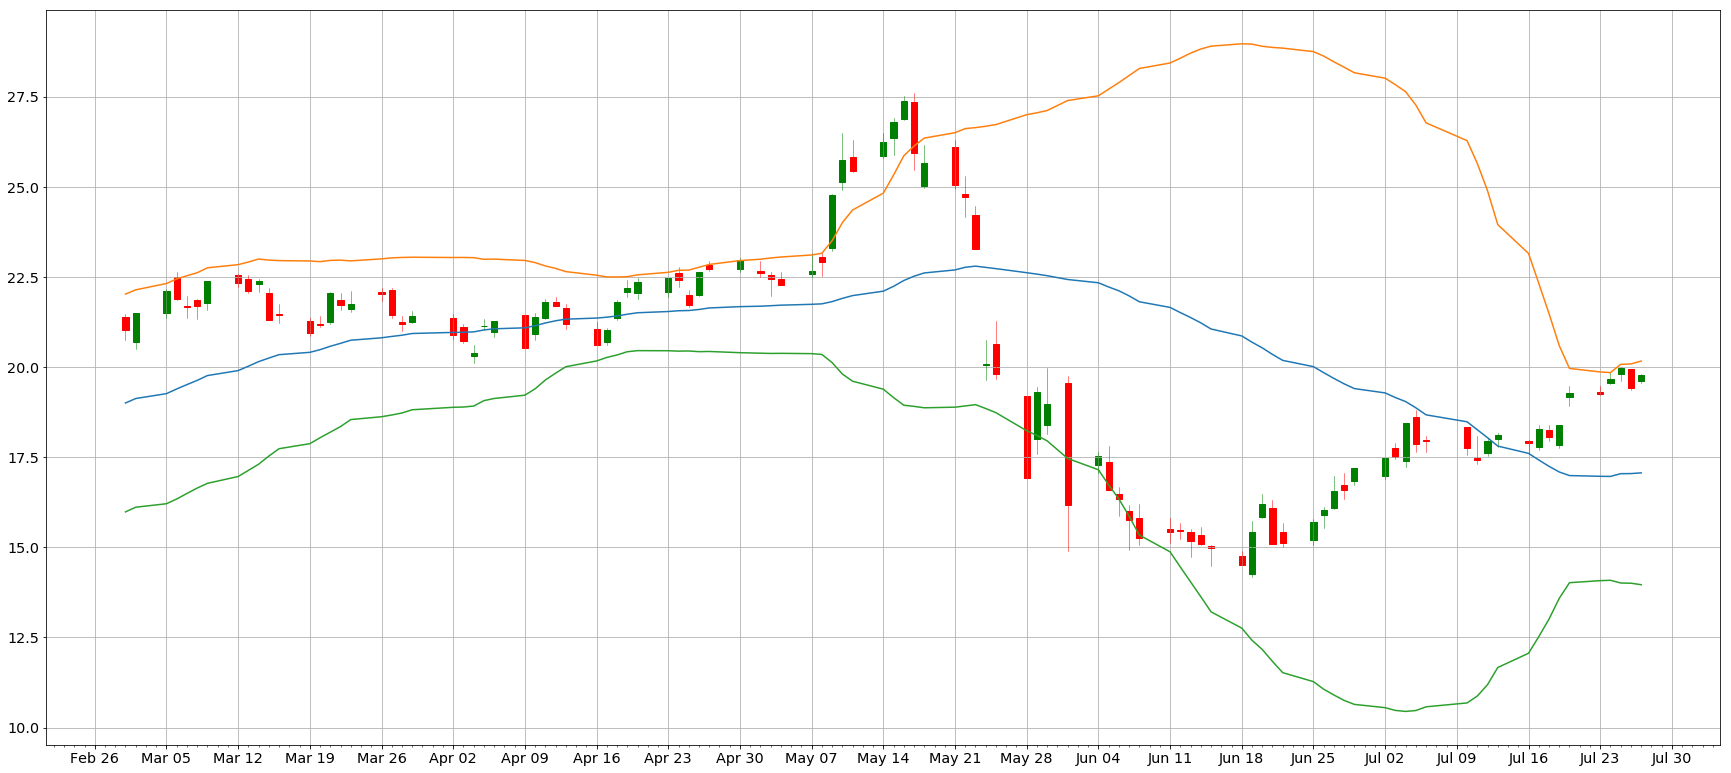

In [269]:
import mpl_finance as candle
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DayLocator, MONDAY
params = {'legend.fontsize': 'medium',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


stock = pd.read_csv('HISTORICO_2018/PETR4_2018', index_col = 'DATA DO PREGAO', parse_dates=True)


stock['date_ax'] = stock.index
stock['date_ax'] = stock['date_ax'].apply(lambda date: date2num(date))

stock = stock.loc['2018-03-01' : '2018-7-28'].reset_index()

candle_values = [tuple(vals) for vals in stock[['date_ax', 'PRECO DE ABERTURA', 'PRECO MAXIMO', 'PRECO MINIMO', 'PRECO FECHAMENTO']].values]


fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
candle.candlestick_ohlc(ax, candle_values, width=0.6, colorup='g',colordown='r');
plt.grid()


mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(weekFormatter)

ax.plot(stock['date_ax'],stock['MA_40'])
ax.plot(stock['date_ax'],stock['BANDA_1_40 SUPERIOR'])
ax.plot(stock['date_ax'],stock['BANDA_1_40 INFERIOR'])


# for each_order in range(len(df)-5):
#     if df['OPERACAO'].iloc[each_order] == 'SELL':
#         cor = 'red'
#     else:
#         cor = 'green'
#         # PARA CONTINUAR PRECISO EXECUTAR ANTES O CODIGO DE PEGAR DF DAS OPERACOES
#     ax.scatter(df['DATA DO PREGAO'].iloc[each_order], df['PRECO'].iloc[each_order], s=1000, c=cor, alpha=.4)

# 3.3.2 - CANDLE REMOVENDO FDS
# NAO RODAR - VERSAO ANTIGA

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpl_finance as candle


def weekday_candlestick(ohlc_data, ax, fmt='%b %d', freq=7, **kwargs):
    """ Wrapper function for matplotlib.finance.candlestick_ohlc
        that artificially spaces data to avoid gaps from weekends """
    
    # Convert data to numpy array
    ohlc_data_arr = np.array(ohlc_data)
    ohlc_data_arr2 = np.hstack(
        [np.arange(ohlc_data_arr[:,0].size)[:,np.newaxis], ohlc_data_arr[:,1:]])
    ndays = ohlc_data_arr2[:,0]  # array([0, 1, 2, ... n-2, n-1, n])

    # Convert matplotlib date numbers to strings based on `fmt`
    dates = mdates.num2date(ohlc_data_arr[:,0])
    date_strings = []
    for date in dates:
        date_strings.append(date.strftime(fmt))

    # Plot candlestick chart
    candle.candlestick_ohlc(ax, ohlc_data_arr2, **kwargs)

    # Format x axis
    ax.set_xticks(ndays[::freq])
    ax.set_xticklabels(date_strings[::freq], rotation=45, ha='right')
    ax.set_xlim(ndays.min(), ndays.max())
    


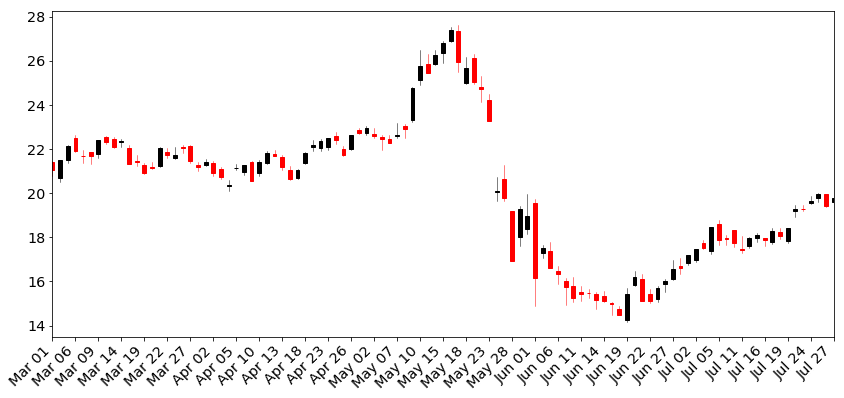

In [137]:
fig, axes = plt.subplots(ncols=1, figsize=(14, 6))
data_1 = candle_values

weekday_candlestick(data_1, ax=axes, fmt='%b %d', freq=3, width=0.5)


# axes.plot(stock['date_ax'],stock['MA_40'])
# axes.plot(stock['date_ax'],stock['BANDA_1_40 SUPERIOR'])
# axes.plot(stock['date_ax'],stock['BANDA_1_40 INFERIOR'])
# ax.plot(stock['date_ax'],stock['MA_40'])
# axes.plot(stock['date_ax'],stock['BANDA_1_40 SUPERIOR'])
# axes.plot(stock['date_ax'],stock['BANDA_1_40 INFERIOR'])


# for each_order in range(len(df)-5):
#     if df['OPERACAO'].iloc[each_order] == 'SELL':
#         cor = 'red'
#     else:
#         cor = 'green'
#         # PARA CONTINUAR PRECISO EXECUTAR ANTES O CODIGO DE PEGAR DF DAS OPERACOES
#     axe.scatter(df['DATA DO PREGAO'].iloc[each_order], df['PRECO'].iloc[each_order], s=1000, c=cor, alpha=.4)


# 3.3.3 - CANDLE COMPLETO SEM FDS

In [217]:
# Pegando as ordens
df = pd.read_csv('BACK_TEST/BollingerBand')
df = df.dropna()
df['DATA DO PREGAO'] = df['DATA DO PREGAO'].apply(lambda name: int(name) )
save_dir = 'BACK_TEST/BollingerBand'
df.to_csv(save_dir,index=False)
orders_df = pd.read_csv('BACK_TEST/BollingerBand', parse_dates=['DATA DO PREGAO'])
orders_df = orders_df[df['CODIGO DE NEGOCIACAO DO PAPEL'] == 'SUZB3'].reset_index()
print(len(df))
orders_df

1203


,index,CODIGO DE NEGOCIACAO DO PAPEL,DATA DO PREGAO,PRECO,OPERACAO
0,39,SUZB3,2018-03-08,22.962671,SELL
1,471,SUZB3,2018-06-19,43.824750,BUY
2,581,SUZB3,2018-07-18,41.154368,BUY
3,646,SUZB3,2018-07-31,44.634500,SELL
4,704,SUZB3,2018-08-13,46.849618,SELL
5,718,SUZB3,2018-08-15,43.905000,BUY
6,745,SUZB3,2018-08-21,47.153261,SELL
7,849,SUZB3,2018-09-20,47.485500,BUY
8,944,SUZB3,2018-10-04,42.265624,BUY
9,1118,SUZB3,2018-11-30,39.480000,SELL


In [218]:
# Pegando os dados
stock = pd.read_csv('HISTORICO_2018/SUZB3_2018', index_col = 'DATA DO PREGAO', parse_dates=True)
stock['date_ax'] = stock.index
stock['date_ax'] = stock['date_ax'].apply(lambda date: date2num(date))

# Intervalo desejado
stock = stock.loc['2018-03-01' : '2018-12-28'].reset_index()

candle_values = [tuple(vals) for vals in stock[['date_ax', 'PRECO DE ABERTURA', 'PRECO MAXIMO', 'PRECO MINIMO', 'PRECO FECHAMENTO']].values]


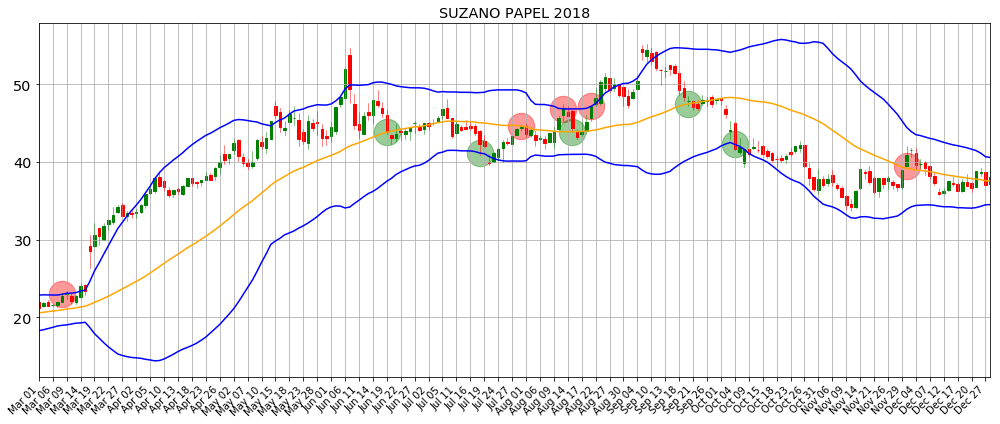

In [222]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(ncols=1, figsize=(14, 6))

# Parâmetros pro candle plot
fmt='%b %d'
freq=3
width=0.55
ohlc_data = candle_values

# Remover Final de Semana
# Convert data to numpy array 
ohlc_data_arr = np.array(ohlc_data)
ohlc_data_arr2 = np.hstack(
    [np.arange(ohlc_data_arr[:,0].size)[:,np.newaxis], ohlc_data_arr[:,1:]])
ndays = ohlc_data_arr2[:,0]  # array([0, 1, 2, ... n-2, n-1, n])

# Convert matplotlib date numbers to strings based on `fmt`
dates = mdates.num2date(ohlc_data_arr[:,0])
date_strings = []
for date in dates:
    date_strings.append(date.strftime(fmt))

# Plot candlestick chart
candle.candlestick_ohlc(ax, ohlc_data_arr2, width, colorup = 'g', colordown = 'r')
plt.grid()

mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(weekFormatter)

# Plot indicadores
ax.plot(ohlc_data_arr2[:,0],stock['MA_40'], color = "orange")
ax.plot(ohlc_data_arr2[:,0],stock['BANDA_1_40 SUPERIOR'], color = "blue")
ax.plot(ohlc_data_arr2[:,0],stock['BANDA_1_40 INFERIOR'], color = "blue")

# Formating
ax.set_xticks(ndays[::freq])
ax.set_xticklabels(date_strings[::freq], rotation=45, ha='right', fontsize='medium')
ax.set_xlim(ndays.min(), ndays.max())
ax.set_title(stock['NOME RESUMIDO DA EMPRESA EMISSORA'].iloc[0] + " 2018")
plt.tight_layout()
plt.grid()

# Adjusting order index
new_order_id = []
order_id = 0
for each in range(len(stock)):
    if orders_df['DATA DO PREGAO'].iloc[order_id] == stock['DATA DO PREGAO'].iloc[each]:
        new_order_id.append(each)
        order_id = order_id + 1
    if order_id >= len(orders_df):
        break
    

# Plot ordens

for each_order in range(len(new_order_id)):
    if orders_df['OPERACAO'].iloc[each_order] == 'SELL':
        cor = 'red'
    else:
        cor = 'green'
    ax.scatter(new_order_id[each_order],orders_df['PRECO'].iloc[each_order], s=700, c=cor, alpha=.4)
plt.grid()


# 3.4.1 - ANÁLISE QUANTITATIVA - LUCROS INDIVIDUAIS

In [223]:
# Pega ordens:
df = pd.read_csv('BACK_TEST/BollingerBand')
df = df.dropna()
df['DATA DO PREGAO'] = df['DATA DO PREGAO'].apply(lambda name: int(name) )
save_dir = 'BACK_TEST/BollingerBand'
df.to_csv(save_dir,index=False)
orders_df = pd.read_csv('BACK_TEST/BollingerBand', parse_dates=['DATA DO PREGAO'])
print(len(orders_df))
orders_df.head()

1203


,CODIGO DE NEGOCIACAO DO PAPEL,DATA DO PREGAO,PRECO,OPERACAO
0,ABEV3,2018-03-01,22.529268,SELL
1,GGBR4,2018-03-01,17.090248,SELL
2,MGLU3,2018-03-01,90.794397,SELL
3,GOAU4,2018-03-01,8.114165,SELL
4,UGPA3,2018-03-01,75.205725,BUY


In [224]:
orders_df.tail()

,CODIGO DE NEGOCIACAO DO PAPEL,DATA DO PREGAO,PRECO,OPERACAO
1198,WEGE3,2018-12-28,17.838750,SELL
1199,IGTA3,2018-12-28,40.675920,SELL
1200,MRVE3,2018-12-28,12.148000,SELL
1201,ENBR3,2018-12-28,14.460427,SELL
1202,TEND3,2018-12-28,31.816305,SELL


In [225]:
# Pega id das ordens não fechadas
id_to_remove = []
blue_chips = pd.read_csv('BLUECHIPS')
for bc_code in blue_chips['CODIGO DE NEGOCIACAO DO PAPEL']:
    df = orders_df[orders_df['CODIGO DE NEGOCIACAO DO PAPEL'] == bc_code].reset_index()
    if len(df)%2:
        id_to_remove.append(df.iloc[len(df)-1]['index'])

In [226]:
# Remove as ordens nao fechadas pelo id
lucro = 0
id_to_remove.sort(reverse=True)
for each_id in id_to_remove:
    orders_df = orders_df.drop(orders_df.index[each_id])
id_to_remove = []
print(len(orders_df))

1146


In [227]:
# Armazena os lucros individuais de cada ordem

ordem_fechada = []
for bc_code in blue_chips['CODIGO DE NEGOCIACAO DO PAPEL']:
    df = orders_df[orders_df['CODIGO DE NEGOCIACAO DO PAPEL'] == bc_code].reset_index()
    for i in range(int(len(df)/2)):
        i = i*2
        if df.iloc[i]['OPERACAO'] == 'BUY':
            # Se eu comprei antes, lucro = venda futura - compra presente
            lucro = (df.iloc[i+1]['PRECO'] - df.iloc[i]['PRECO'])/df.iloc[i]['PRECO']
        else:
            # Se eu vendi antes, lucro = venda atual - compra futura
            lucro = (df.iloc[i]['PRECO'] - df.iloc[i+1]['PRECO'])/df.iloc[i]['PRECO']
        ordem_fechada.append(lucro*100)
        
        if lucro*100 < -50:
            print("Pessimas operacoes: " + df.iloc[i]['CODIGO DE NEGOCIACAO DO PAPEL'])

Pessimas operacoes: SUZB3
Pessimas operacoes: ELPL3


In [228]:
# SUZB3 : https://www1.folha.uol.com.br/mercado/2018/03/suzano-e-fibria-criam-gigante-da-celulose.shtml
# ELPL3 : https://economia.estadao.com.br/noticias/geral,enel-compra-eletropaulo-e-se-torna-a-maior-distribuidora-de-energial-do-pais,70002337383

Quantidade de ordens: 573
Média de lucro das ordens: 0.33764026980140843
Somatório de lucro individual: 193.46787459620703


<BarContainer object of 573 artists>

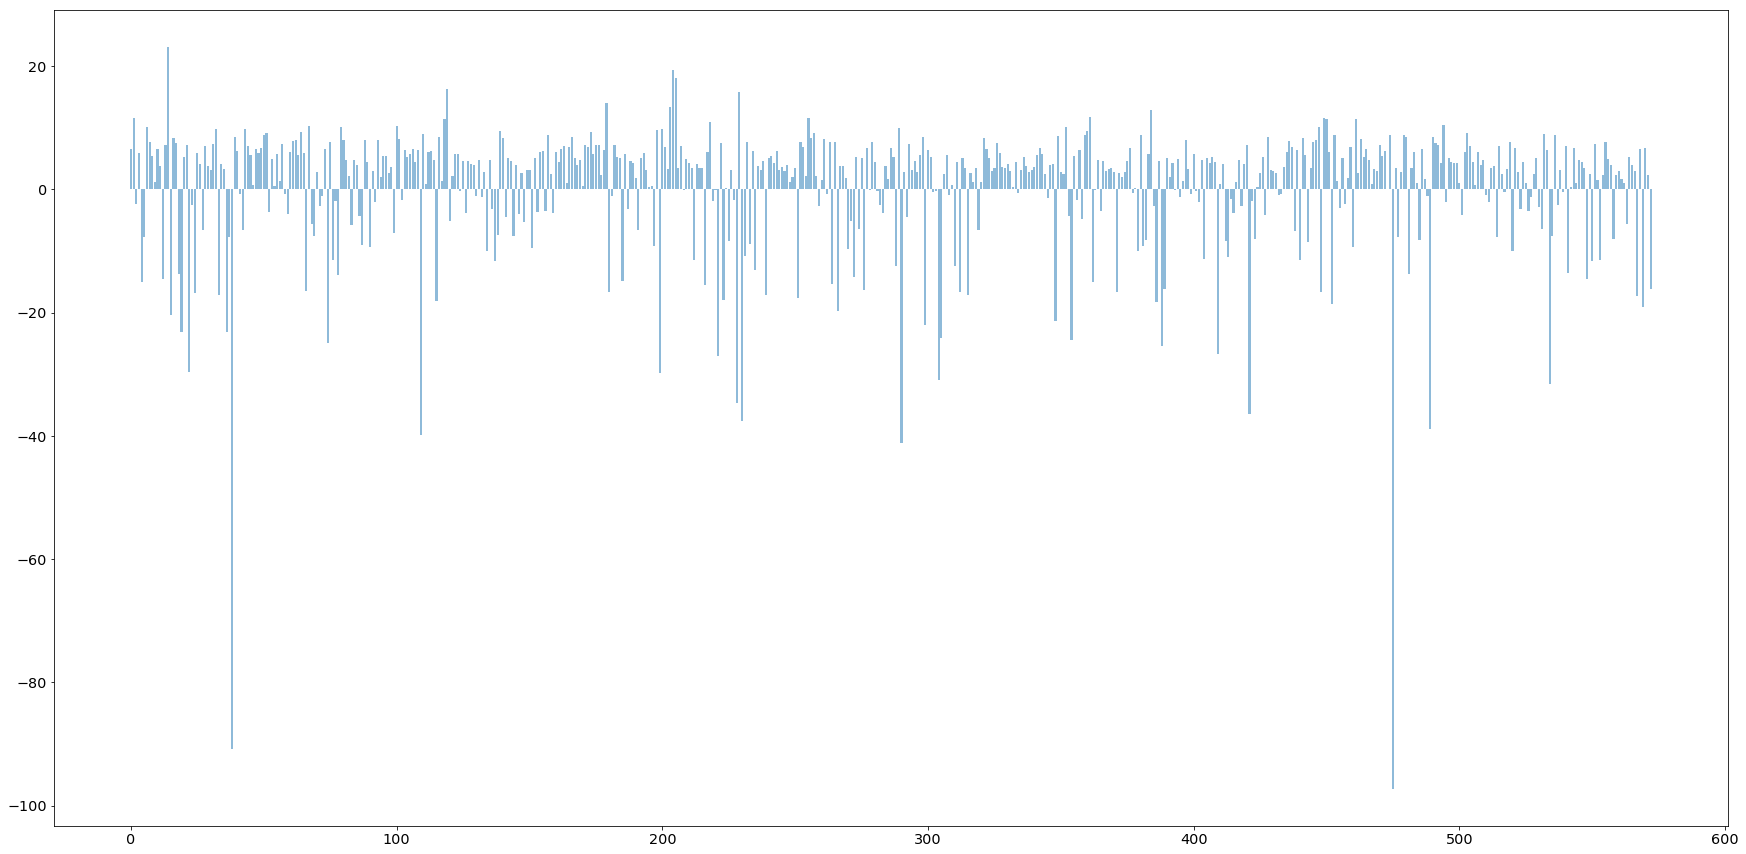

In [229]:
print("Quantidade de ordens: " + str(len(ordem_fechada)))
print("Média de lucro das ordens: " + str(sum(ordem_fechada)/len(ordem_fechada)))
print("Somatório de lucro individual: " + str(sum(ordem_fechada)))
x_values = np.arange(len(ordem_fechada))
plt.bar(x_values, ordem_fechada, align='center', alpha=0.5)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,
         1.,  0.,  1.,  1.,  2.,  0.,  2.,  0.,  1.,  1.,  1.,  1.,  0.,
         2.,  3.,  2.,  7.,  5.,  1.,  3.,  4.,  3.,  2.,  0.,  2.,  7.,
         2.,  1.,  4.,  6.,  4.,  7.,  5.,  6.,  1.,  4.,  3.,  6., 11.,
         4., 10., 10.,  9., 11., 13., 10., 17., 11., 18., 36., 30., 34.,
        32., 36., 28., 30., 25., 17., 21., 13.,  9.

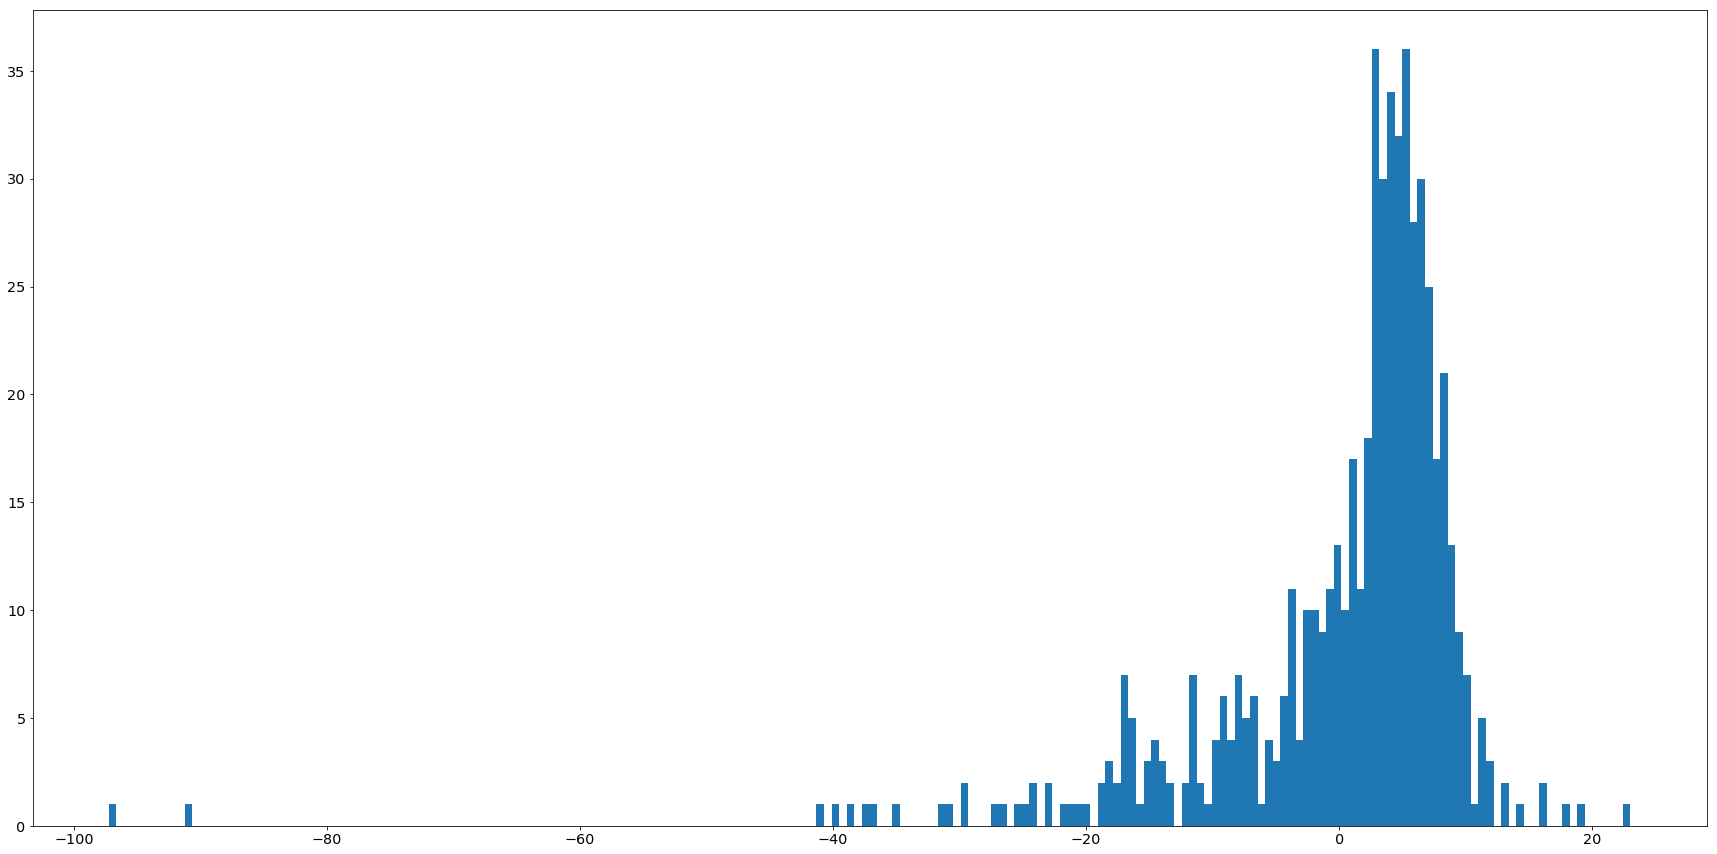

In [230]:
plt.hist(ordem_fechada,bins=200)

# 3.4.2 - ANÁLISE QUANTITATIVA - DESEMPENHO DA CARTEIRA

In [231]:
# Carteira inicial R$ 1.000.000
melhor_carteira = 0
best_p = 0
for porcentagem in range(70):
    porcentagem = porcentagem + 20
    carteira = 1000000
    carteira_hist = [1000000]
    for i in range(len(orders_df)):
        order = orders_df.iloc[i]
        disponivel = carteira/(100)
        quantidade_papel = round(disponivel/order['PRECO'])
        if order['OPERACAO'] == 'BUY':
            carteira = carteira - quantidade_papel* order['PRECO']
        elif order['OPERACAO'] == 'SELL':
            carteira = carteira + quantidade_papel* order['PRECO']
        carteira_hist.append(carteira)
    if carteira > melhor_carteira:
        melhor_carteira = carteira
        best_p = porcentagem
best_p = best_p + 1

In [232]:
print(best_p)
print("Valor final da carteira: ")
print(melhor_carteira)
print("\nPorcentagem em cada operação: ")
print(100/best_p)

((melhor_carteira - 1000000)/1000000) * 100

21
Valor final da carteira: 
944748.753380343

Porcentagem em cada operação: 
4.761904761904762


-5.5251246619657035

In [233]:
carteira = 1000000
carteira_hist = [1000000]
for i in range(len(orders_df)):
    order = orders_df.iloc[i]
    disponivel = carteira/100
    quantidade_papel = round(disponivel/order['PRECO'])
    if order['OPERACAO'] == 'BUY':
        carteira = carteira - 100* order['PRECO']
    elif order['OPERACAO'] == 'SELL':
        carteira = carteira + 100* order['PRECO']
    carteira_hist.append(carteira)
carteira

1000429.1434244186

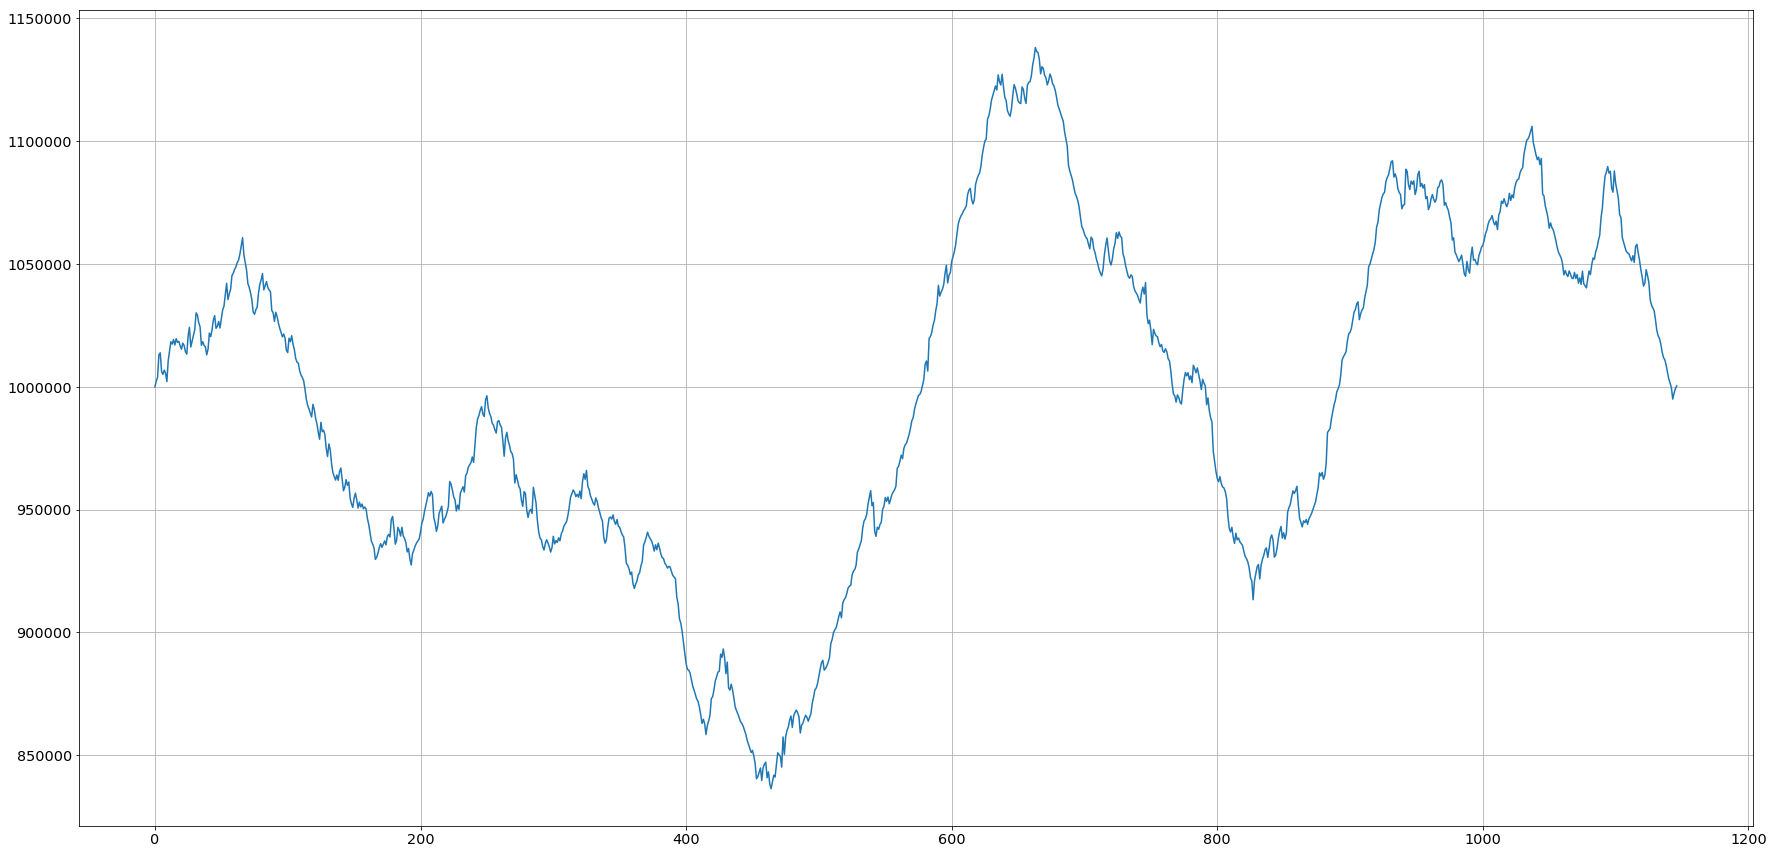

In [234]:
plt.plot(carteira_hist)
plt.grid()
rcParams['figure.figsize'] = 30, 15
